In [3]:
import sys
print(sys.version)

3.7.4 (v3.7.4:e09359112e, Jul  8 2019, 14:54:52) 
[Clang 6.0 (clang-600.0.57)]


In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import pickle
from os import listdir
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
#tqdm.pandas()
from time import time

In [6]:
#read files

#description: https://www.kaggle.com/gspmoreira/news-portal-user-interactions-by-globocom

articles_metadata = pd.read_csv('data/articles_metadata.csv')
clicks_sample = pd.read_csv('data/clicks_sample.csv')


with open('data/articles_embeddings.pickle', 'rb') as pickle_file:
    embeddings = pickle.load(pickle_file)

In [9]:
print('articles_metadata')
display(articles_metadata.head())
print('clicks_sample')
display(clicks_sample.head())
print('embeddings shape')
print(embeddings.shape)

articles_metadata


,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


clicks_sample


,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


embeddings shape
(364047, 250)


In [5]:
def get_click_data():
    click_dir = 'data/clicks/clicks/'
    columns = ['user_id','click_article_id','click_environment','click_deviceGroup'] #validate with EDA
    return pd.concat(
        pd.read_csv(click_dir + click_data)[columns] for click_data in tqdm(listdir('data/clicks/clicks'))
    ).drop_duplicates()

In [6]:
# user_clicks = get_click_data()

In [7]:
display(user_clicks.head(),user_clicks.nunique())

,user_id,click_article_id,click_environment,click_deviceGroup
0,0,157541,4,3
1,0,68866,4,3
2,1,235840,4,1
3,1,96663,4,1
4,2,119592,4,1


user_id              322897
click_article_id      46033
click_environment         3
click_deviceGroup         5
dtype: int64

# Model 1: User Latent Vectors

In [10]:
df_x = pd.read_csv('data/df_x.csv',index_col=0)

In [11]:
class LinearModel:
    def __init__(self, user_data, item_embeddings, size=8, embeddings_size=250, T=1):
        self.user_data = user_data
        self.item_embeddings = item_embeddings
        self.T = T
        self.Vd = LinearModel.d.get_embedding_vectors(
            item_embeddings, user_data, size, embeddings_size=embeddings_size
        )
        self.U = self.initialize_user_vectors(
            size=size,embeddings_size=embeddings_size
        )
        self.instantiate_errors()
        
    def initialize_user_vectors(self,size,embeddings_size=250):
        return np.mean(LinearModel.d.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size
        ),axis=1) #.repeat(size,axis=0).reshape(-1,size,embeddings_size)
        
    def instantiate_errors(self):
        #this is for tracking in steps of SGD
        self.errors = []
    
    #############################
    ###### SEEN AND UNSEEN ######
    #############################
    
    class d:
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250):
            return np.hstack(V_embeddings[df.click_article_id.to_list()]).reshape(-1,size,embeddings_size)
    
    class dbar:
        @staticmethod
        def get_unseen(df, u, size, len_):
            return np.random.choice(
                np.delete(
                    np.arange(len_),
                    df[df.index.get_level_values(0)==u].click_article_id,
                ),
                size=size,
            )
        
        @staticmethod
        def get_all_unseen(df, size, len_=364047):            
            #semi-vectorized version
            return np.hstack(pd.DataFrame(
                df.index.get_level_values(0)
            ).drop_duplicates().user_id.map(
                lambda u: LinearModel.dbar.get_unseen(df, u, size, len_)
            ))
        
        @staticmethod
        def get_embedding_vectors(V_embeddings, df, size, embeddings_size=250, len_=36047):
            return np.hstack(
                V_embeddings[LinearModel.dbar.get_all_unseen(df,size,len_=len_).tolist()]
            ).reshape(
                -1,
                size,
                embeddings_size
            )
    
    #########################
    ##### SGD UTILITIES #####
    #########################
    
    class gradient: 
        @staticmethod
        def J(U,Vd,Vdbar, size=8, embedding_size=250,hinge_param=1):

            
            
#             return np.sum(
#                 np.multiply(
#                     hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0] > 0,
#                     np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
#                 )
#             )


            cost = hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0] - np.tensordot(U,Vd,axes=(1,2))[0]
            return np.sum(
                np.max(
                    [np.zeros((U.shape[0],size)), cost], axis = 0
                )
            )
        
        @staticmethod
        def dJ(U,Vd,Vdbar,size=8,embedding_size=250,hinge_param=1):
            #conditional derivitive
            
            return np.sum(
                (
                    hinge_param + np.tensordot(U,Vdbar,axes=(1,2))[0]
                    - np.tensordot(U,Vd,axes=(1,2))[0] < 0
                ).repeat(
                    embedding_size
                ).reshape(-1,size,embedding_size) * (Vdbar - Vd),
                axis=1
            )
    
    ##### STOCHASTIC GRADIENT DESCENT ####

    
    #
    def SGD(self):
        #instantiate progress bar with tqdm
        #SGD_vectorized should be wrapped in here
        pass
    
    
    
    def SGD_vectorized(
        self,
        alpha=0.1,
        size=8,
        test_size=128,
        embeddings_size=250,
        test=True,
        hinge_param=1,
        iteration=0,
        max_iterations=500
    ):
        #Stochastic Gradient Descent

        #print('Vd', self.item_embeddings[0,0:10])
        
        #resample stuff
        Vdbar_small = LinearModel.dbar.get_embedding_vectors(
            self.item_embeddings,
            self.user_data,
            size,
            embeddings_size=embeddings_size,
        )

        self.U = self.U - alpha * LinearModel.gradient.dJ(
            self.U,
            self.Vd,
            Vdbar_small,
        ) #fix this
        
        
        while True:
            if test == True:
                Vdbar_big = LinearModel.dbar.get_embedding_vectors(
                    self.item_embeddings,
                    self.user_data,
                    test_size,
                    embeddings_size=embeddings_size,
                )
                
                J = LinearModel.gradient.J(
                    self.U,
                    self.Vd.repeat(test_size/size,axis=1),
                    Vdbar_big,
                    size=test_size,
                    embedding_size=250,
                    hinge_param=1
                )
                # the Vd reshape still needs to be fixed
                
                self.errors.append(J)
                
            if iteration == max_iterations:
                #stop iterating
                #display errors

                sns.lineplot(
                    x = range(len(self.errors)),
                    y = self.errors
                )
                return self.U
            #print(iteration)
            iteration += 1
            return self.SGD_vectorized(
                alpha=alpha, 
                size=size,
                test_size=test_size,
                embeddings_size=embeddings_size,
                test=test, 
                hinge_param=hinge_param,
                iteration=iteration, 
                max_iterations=max_iterations)

#### Test out Pipeline

[-0.26824254 -0.9636772  -0.28512946 -0.32596728 -0.34310314 -0.2655414
 -0.25597954  0.02330121  0.22115023 -0.15524353]
[-0.28336248 -0.9620262  -0.58024484 -0.31000292 -0.8170984  -0.60413224
 -0.29311433  0.23007222  0.49828598 -0.35068867]


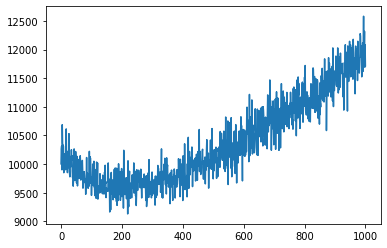

In [12]:
lm = LinearModel(df_x,embeddings,size=8, embeddings_size=250, T=1)
print(lm.U[0,0:10])
lm.SGD_vectorized(test=True,alpha=0.0001, max_iterations=1000, test_size=128)
print(lm.U[0,0:10])

The function minimizes at around 200 iterations.  From now on we'll just stop there.

#### Predict Articles

# Model 2: Multiple User Latent Vectors

In [ ]:
class NonlinearModel():
    pass